In [414]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, sampler, random_split
from matplotlib import pyplot as plt
import torch.nn.functional as F
import os
from PIL import Image
import numpy as np
import pandas as pd
from pathlib import Path

# Create path to data

https://www.kaggle.com/prasunroy/natural-images
Location of data.

https://www.kaggle.com/gabrielloye/pytorch-vgg16-natural-images/data
Looked up some code here.

In [415]:
#Assuming data is saved one level above project directory.
path = (Path().resolve().parents[1]).absolute() / "data/natural_images"
path = str(path)

In [416]:
#We see there are 8 different classes.
print(os.listdir(str(path)))

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


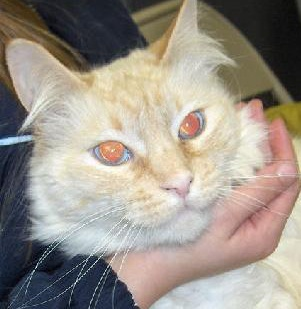

In [417]:
#Look at sample image
Image.open(path + '/cat/cat_0007.jpg')

# Create transforms

In [418]:
image_size= (128,128)

In [419]:
#Can add more later such as random noise if we want to do a denoising task.

image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.Resize(size=image_size),
        #transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val':
    transforms.Compose([
        transforms.Resize(size=image_size),
        #transforms.CenterCrop(size=224),
        transforms.ToTensor(),
       # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=image_size),
        #transforms.CenterCrop(size=224),
        transforms.ToTensor(),
       # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create dataloader and dataset

In [420]:
batch_size = 16

all_data = datasets.ImageFolder(root=path)
train_data_len = int(len(all_data)*0.8)
valid_data_len = int((len(all_data) - train_data_len)/2)
test_data_len = int(len(all_data) - train_data_len - valid_data_len)
train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
train_data.dataset.transform = image_transforms['train']
val_data.dataset.transform = image_transforms['val']
test_data.dataset.transform = image_transforms['test']
print(len(train_data), len(val_data), len(test_data))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True,drop_last=True)

5519 690 690


# Look at a sample image from loader

In [421]:
def imshow_tensor(image, ax=None, title=None):

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
   # mean = np.array([0.485, 0.456, 0.406])
   # std = np.array([0.229, 0.224, 0.225])
   # image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

In [422]:
trainiter = iter(train_loader)
features, labels = next(trainiter)
print(features.shape, labels.shape)

torch.Size([16, 3, 128, 128]) torch.Size([16])


In [423]:
features[0,:,:,:].shape

torch.Size([3, 128, 128])

In [424]:
b = features[0,:,:,:]

In [425]:
b.shape

torch.Size([3, 128, 128])

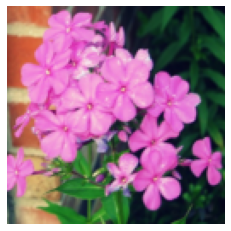

In [426]:
_ = imshow_tensor(features[0,:,:,:])

In [528]:
# Displaying routine
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1,3, image_size[0], image_size[1])
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N].permute(1, 2, 0))
                plt.axis('off')
        out_pic = out.data.cpu().view(-1,3, image_size[0], image_size[1])
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N].permute(1, 2, 0))
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [529]:
# Set random seeds
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [530]:
# Defining the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create model

https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb

In [531]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [532]:
class UnFlatten(nn.Module):
    def forward(self, input, size=4096):
        return input.view(input.size(0), size, 1, 1)

In [533]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=4096, z_dim=512):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=6, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=9, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=10, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=10, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=10, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        #esp = torch.randn(*mu.size())
        esp = std.data.new(std.size()).normal_()
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [534]:
model = VAE().to(device)

In [535]:
# Setting the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [536]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    #BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

====> Val set loss: 33946.2909
====> Epoch: 1 Average loss: 31008.1880
====> Epoch: 2 Average loss: 28563.4343
====> Epoch: 3 Average loss: 27984.9411
====> Epoch: 4 Average loss: 27686.6619
====> Epoch: 5 Average loss: 27528.9310
====> Val set loss: 27366.8735
====> Epoch: 6 Average loss: 27404.9716
====> Epoch: 7 Average loss: 27290.1203
====> Epoch: 8 Average loss: 27170.2504
====> Epoch: 9 Average loss: 27103.8761
====> Epoch: 10 Average loss: 27020.7986
====> Val set loss: 27104.1564
====> Epoch: 11 Average loss: 26988.9813
====> Epoch: 12 Average loss: 26893.9158
====> Epoch: 13 Average loss: 26824.6365
====> Epoch: 14 Average loss: 26769.6989
====> Epoch: 15 Average loss: 26745.8490
====> Val set loss: 26881.5435
====> Epoch: 16 Average loss: 26672.1194
====> Epoch: 17 Average loss: 26620.1067
====> Epoch: 18 Average loss: 26595.6914
====> Epoch: 19 Average loss: 26554.5610
====> Epoch: 20 Average loss: 26513.7032
====> Val set loss: 26820.1991


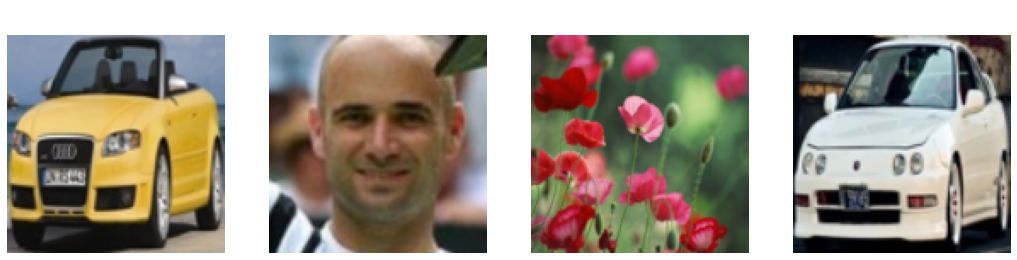

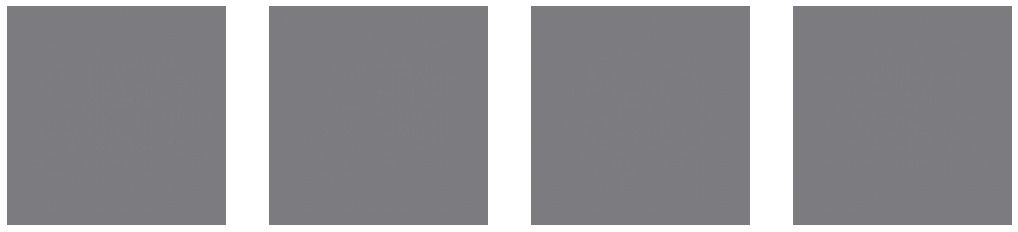

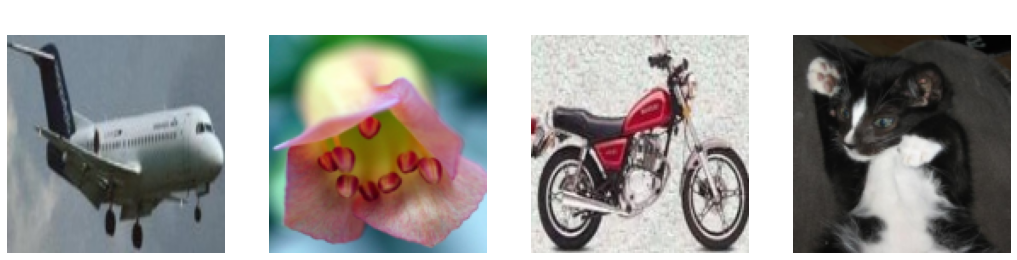

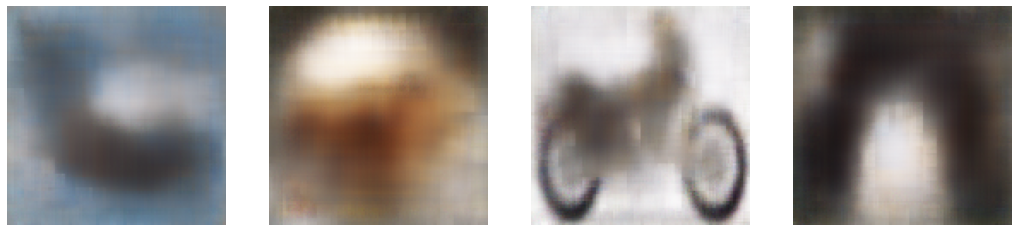

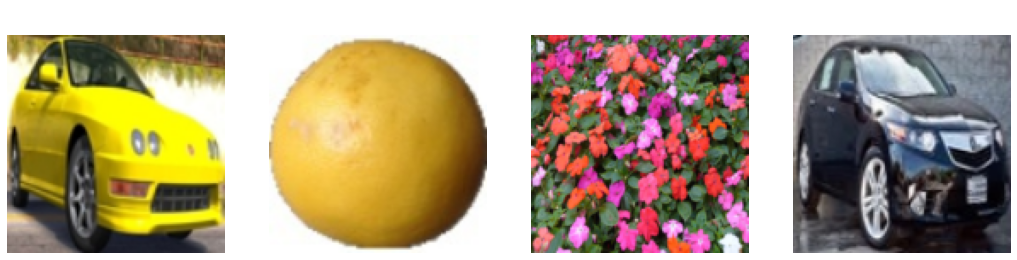

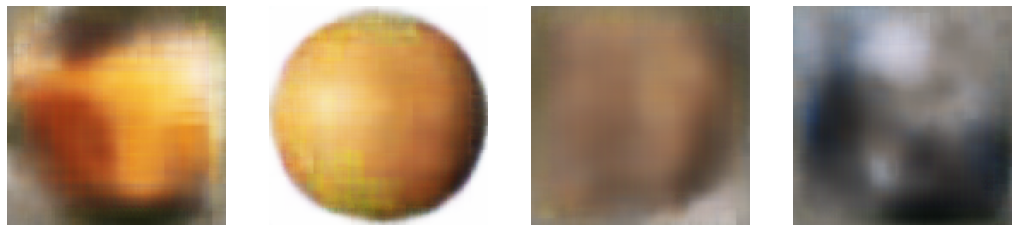

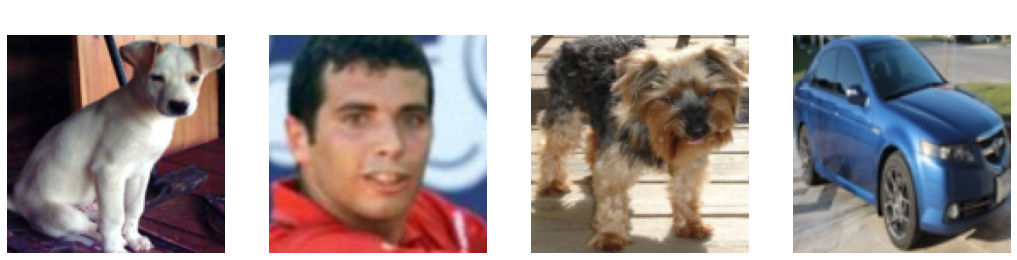

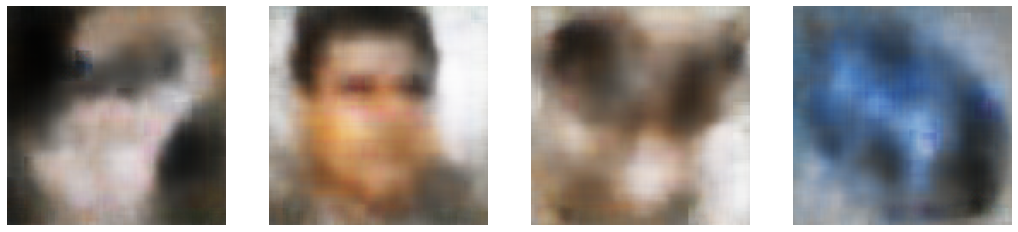

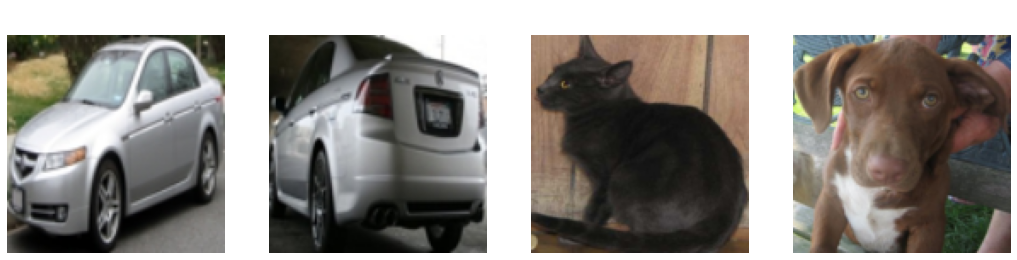

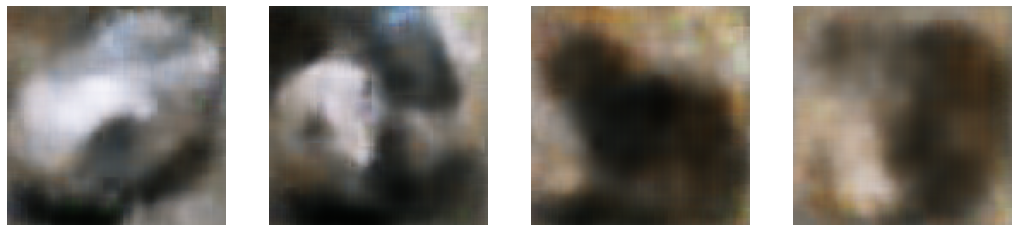

In [537]:
# Training and testing the VAE

epochs = 20
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Validaton
    if epoch % 5 == 0:
        means, logvars, labels = list(), list(), list()
        with torch.no_grad():
            model.eval()
            test_loss = 0
            for x, y in val_loader:
                x = x.to(device)
                # ===================forward=====================
                x_hat, mu, logvar = model(x)
                test_loss += loss_function(x_hat, x, mu, logvar).item()
                # =====================log=======================
                means.append(mu.detach())
                logvars.append(logvar.detach())
                labels.append(y.detach())
        # ===================log========================
        codes['μ'].append(torch.cat(means))
        codes['logσ2'].append(torch.cat(logvars))
        codes['y'].append(torch.cat(labels))
        test_loss /= len(test_loader.dataset)
        print(f'====> Val set loss: {test_loss:.4f}')
        display_images(x, x_hat, 1, f'Epoch {epoch}')

# Generate images

Below is taken from Alfs DL notebooks. We dont need them but just keeping them here in case we want to do similar things at some point.

In [ ]:
# Generating a few samples

N = 16
z = torch.randn((N, d)).to(device)
sample = model.decoder(z)
display_images(None, sample, N // 4, count=True)

In [ ]:
# Display last test batch

display_images(None, x, 4, count=True)

# Interpolation

In [ ]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed

A, B = 1, 14
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1),
    sample.data[0],
    sample.data[1]
)), 0))

In [ ]:
# Perform an interpolation between input A and B, in N steps

N = 16
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
sample = model.decoder(code)
display_images(None, sample, N // 4, count=True)

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
#from res.plot_lib import set_default

In [ ]:
#set_default(figsize=(15, 4))

In [ ]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1].cpu()))
    Y.append(codes['y'][epoch][:N])

In [ ]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)